# CHAMPS Dataset Scalar Coupling

- Michael Follari
- [Predicting Molecular Properties](https://www.kaggle.com/c/champs-scalar-coupling)
- UNCG Physics 2020
- Dr. Ajay Covell

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

More plot styling can be found [here.](https://matplotlib.org/tutorials/introductory/customizing.html)

In [2]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams.update({'font.size': 16})

# Data Sets
* structures.csv - `structures_df` - Contains the xyz coordinates of each atom within each molecule
* train.csv - `train_df` - Contains the type and scalar_coupling_constant between every atoms pair within each molecule.

### The following code imports both the above datasets, merges, and adds additional columns.
* Only added column is currently displacement between the two atoms in the bond.

In [3]:
structure_path = 'D:\data\champs\zip\structures.zip'
train_path = 'D:\data\champs\zip\\train.zip'
test_path = 'D:\data\champs\zip\\test.zip'
train_bond_path = 'D:\data\champs\zip\\train_bond.gz'
test_bond_path = 'D:\data\champs\zip\\test_bond.gz'

In [4]:
# Load in Structure and Train CSV files, merge, calculate values, and save to Molecules CSV
def merge_struct_dataset(path_struct, path_train, path_merged):
    
    # load in struct and train datasets
    structures_df = pd.read_csv(path_struct)
    train_df = pd.read_csv(path_train)

    # Merge structure data onto train_df for each atom (atom_index_0 and atom_index_1). Hold in mol_df
    mol_df = train_df.merge(structures_df, left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'])
    mol_df = mol_df.merge(structures_df, left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'])

    # drop extra columns from merge and rename
    mol_df.drop(['atom_index_x','atom_index_y'], axis=1, inplace=True)
    mol_df.rename(columns={'atom_x':'atom_0','atom_y':'atom_1','x_x':'x_0','y_x':'y_0','z_x':'z_0','x_y':'x_1','y_y':'y_1','z_y':'z_1'}, inplace=True)
    
    # Append new columns with calculated values
    mol_df = append_molecule_calculations(mol_df)
    
    # Save to CSV
    mol_df.to_csv(path_merged, compression="gzip")
    
# adds new columns with calculated values to molecule df
def append_molecule_calculations(mol_df):
    mol_df = calculate_molecule_displacement(mol_df)
    return mol_df
    
# calculates the displacement for each atom interaction 
def calculate_molecule_displacement(mol_df):
    mol_df['displacement'] = mol_df.apply(lambda row: calc_disp(row), axis=1)
    return mol_df
    
# calculcates displacement on a passed row
def calc_disp(row):
    return np.linalg.norm(np.array([row['x_1']-row['x_0'],row['y_1']-row['y_0'],row['z_1']-row['z_0']]))

### Merge strucutre data with train and test data sets.
* Only need to do once to generaete and save to dataframes as CSV files, then load as normla CSV

In [5]:
# merge_struct_dataset(structure_path, train_path, train_bond_path)
# merge_struct_dataset(structure_path, test_path, test_bond_path)

#### Load merged datasets

In [6]:
bond_df = pd.read_csv( train_bond_path )

In [7]:
bond_df

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,displacement
0,0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,4,dsgdb9nsd_000001,2,0,1JHC,84.807400,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952
2,2,7,dsgdb9nsd_000001,3,0,1JHC,84.809300,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001,1.091946
3,3,9,dsgdb9nsd_000001,4,0,1JHC,84.809500,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001,1.091948
4,4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,4659071,4659040,dsgdb9nsd_133884,13,17,3JHH,3.062820,H,2.582409,-1.260138,0.293499,H,1.126550,-1.348733,-1.933838,2.662406
4659072,4659072,4659067,dsgdb9nsd_133884,16,17,3JHH,0.789559,H,-0.084531,1.110807,-1.796741,H,1.126550,-1.348733,-1.933838,2.744968
4659073,4659073,4659038,dsgdb9nsd_133884,13,14,3JHH,1.005250,H,2.582409,-1.260138,0.293499,H,2.087537,1.391489,0.548687,2.709455
4659074,4659074,4659039,dsgdb9nsd_133884,13,15,3JHH,1.005260,H,2.582409,-1.260138,0.293499,H,1.542918,0.547487,2.023550,2.709451


In [8]:
# test_bond_df = pd.read_csv( test_bond_path )
# test_bond_df.head()

In [9]:
# test_df = pd.read_csv( test_path )
# struct_df = pd.read_csv( structure_path )

# Exploration
* Simple Regression of Scalar Coupling & Atom Displacement.

In [10]:
def score_type( y_test, y_calc ):
    y = list(zip(y_test, y_calc))
    error = sum( [abs(i - j) for i, j in y] )
    return np.log10( error / len(y) )

def score_total(sum_score, num_type):
    return sum_score / num_type

def score(types_data):
    
    total_score = 0
    for typ in types_data:
        total_score += score_type(typ)
    return total_score / len(types_data)

### The different kinds of bonds present in the data

In [11]:
bond_types = bond_df.type.unique()
print(bond_types)

['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


#### Fetching and train/test splitting of data for regressions

In [12]:
def get_displacement_coupling(df, bond_type):
    df = df[ df.type == bond_type].sort_values(by=['displacement'])
    # Split and return into x and y arrays
    x = df['displacement'].values
    y = df['scalar_coupling_constant'].values
    return np.array([x,y])

#### Plotting data points and models

In [66]:
def plot_model( x_test, y_test, y_regs, title, x_bound=[None,None], y_bound=[None,None]):
    
    xmin = x_test.min() if x_bound[0] is None else x_bound[0]
    xmax = x_test.max() if x_bound[1] is None else x_bound[1]
    ymin = y_test.min() if y_bound[0] is None else y_bound[0]
    ymax = y_test.max() if y_bound[1] is None else y_bound[1]
    
    plt.scatter(x_test,y_test)
    
    for y_reg in y_regs:
        plt.plot(x_test, y_reg, linewidth=3, linestyle='solid')
    
#     plt.xlim([xmin * 0.99,xmax * 1.01])
#     plt.ylim([ymin * 0.99,ymax* 1.01])
    plt.title(title, size=22)
    plt.xlabel('Displacement', size=22)
    plt.ylabel('Scalar Coupling Constant', size=22)
#     plt.show()

# Linear Regression
- [scikit Learn Linear Regression](https://scikit-learn.org/stable/modules/linear_model.html)

In [14]:
def linear_regression(x_train, y_train, x_test):
    # Train linear regression model
    linear_reg = train_linear_regression(x_train, y_train)
    
    # Use linear regression to generate y value
    return np.array(line_data_points(x_test,linear_reg.coef_, linear_reg.intercept_)).T[0]
    
def train_linear_regression(x,y):
    # Linear Regression fit
    reg = linear_model.LinearRegression()
    reg.fit( x.reshape(-1,1), y )
    return reg

def line_data_points(x_array, coef, intercept):
    return [line_func(x, coef, intercept) for x in x_array]

def line_func(x, coef, intercept):
    return x*coef + intercept

# Random Forest Regression
* [scikit Learn Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [15]:
def random_forest(x_train, y_train, x_test):
    # Train Random Forest regression model
    random_forest_reg = train_rand_forest(x_train, y_train)
    
    # Use Random Forest regression to generate y values
    return random_forest_reg.predict(x_test.reshape(-1,1))

def train_rand_forest(x, y):
    # Train Random Forest
    reg = RandomForestRegressor(max_depth=2, random_state=0)
    reg.fit(x.reshape(-1,1), y)
    return reg

### Trains models for data

In [23]:
def evaluate_models(plot=False):

    title = "Regression of Scalar-Coupling-Constant vs. Bond Displacement : "
    
#     fig = plt.figure()
#     ax = fig.add_subplot(10)
    
    sum_score = 0;
    for bond_type in bond_types:

        # Get x y test/train. Displacement and Bond strength
        x, y = get_displacement_coupling(bond_df, bond_type )
                
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
        x_test.sort() # Sort training values (mostly for plotting)

        # Train and predict Linear regression
        y_linear_regression = linear_regression(x_train, y_train, x_test)

        # Train and predict Random Forest
        y_random_forest_regression = random_forest(x_train, y_train, x_test)

        # Calculate score for regression on type
        linear_score = score_type( y_test, y_linear_regression) 
        forest_score = score_type( y_test, y_random_forest_regression) 

        # Print result
        print(bond_type + ' has score :     Linear: ', round(linear_score, 5), '     Forest: ', round(forest_score,5 ))
        
        # Plot only if desired
        if plot:
            y_regs = [y_linear_regression, y_random_forest_regression]
            plot_model(x_test, y_test, y_regs, title+bond_type,[x_train.min(),x_train.max()], [y_train.min(),y_train.max()])

1JHC has score :     Linear:  1.1961      Forest:  1.18678
2JHH has score :     Linear:  0.4919      Forest:  0.51331
1JHN has score :     Linear:  1.06086      Forest:  1.07067
2JHN has score :     Linear:  0.47403      Forest:  0.49034
2JHC has score :     Linear:  0.46985      Forest:  0.48742
3JHH has score :     Linear:  0.49747      Forest:  0.53898
3JHC has score :     Linear:  0.41158      Forest:  0.42091
3JHN has score :     Linear:  0.0032      Forest:  0.0161


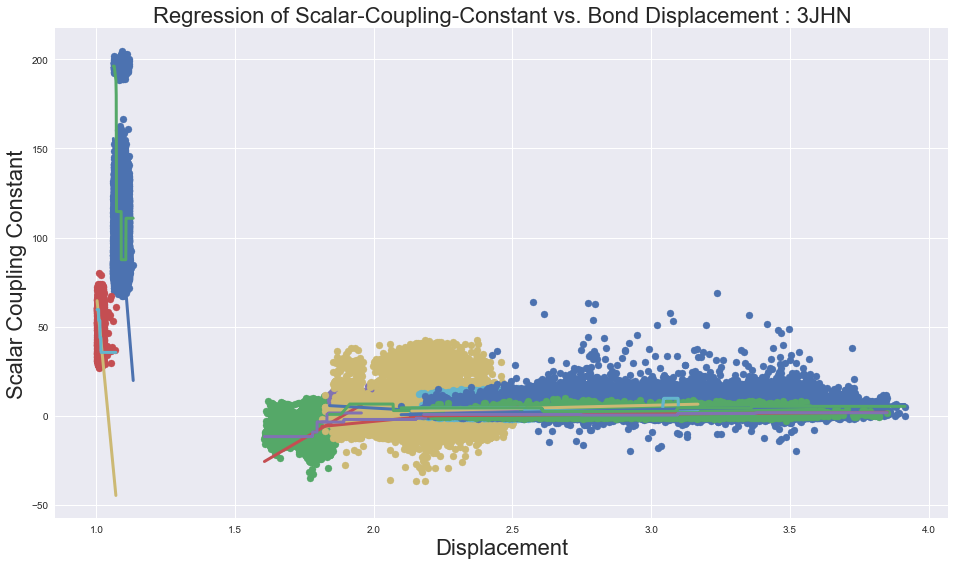

In [67]:
evaluate_models(True)

# Clustering

In [25]:
from sklearn.cluster import KMeans
from sklearn import cluster

bond_type = bond_types[0]
x, y = get_displacement_coupling(bond_df, bond_type )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
x_test.sort() # Sort training values (mostly for plotting)

X_train = np.array([list(a) for a in list(zip(x_train,y_train))])
X_test = np.array([list(a) for a in list(zip(x_test,y_test))])

In [26]:
num_clusters = 4;

In [27]:
X_train

array([[  1.09723684,  87.4991    ],
       [  1.07826197, 126.792     ],
       [  1.09410159,  84.396     ],
       ...,
       [  1.09389809,  82.6843    ],
       [  1.09453296,  92.8103    ],
       [  1.09681436,  88.9705    ]])

### Spectral Clustering

In [28]:
# spectral = cluster.SpectralClustering(
#         n_clusters=num_clusters, eigen_solver='arpack',
#         affinity="nearest_neighbors")
    
# spectral.fit(X_train)
# y_spectral = spectral.predict(X_test)

### Agglomerative Clusrtering

In [31]:
# ward = cluster.AgglomerativeClustering(
#         n_clusters=num_clusters, linkage='ward')
# ward.fit(X_train)
# y_ward = ward.predict(X_test)

### KMeans Clustering

In [ ]:
est = KMeans(num_clusters)
est.fit(X_train)
y_kmeans = est.predict(X_test)


In [ ]:
X_test

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_spectral, s=50, cmap='rainbow');

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
XX, yy = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
# plt.scatter(XX[:, 0], XX[:, 1], s=50);

In [ ]:
XX;

In [ ]:
est = KMeans(4)  # 4 clusters
est.fit(XX)
y_kmeans = est.predict(XX)
# plt.scatter(XX[:, 0], XX[:, 1], c=y_kmeans, s=50, cmap='rainbow');

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<small><small><small>This holds space so I can scroll further</small></small></small>

# XGBoost

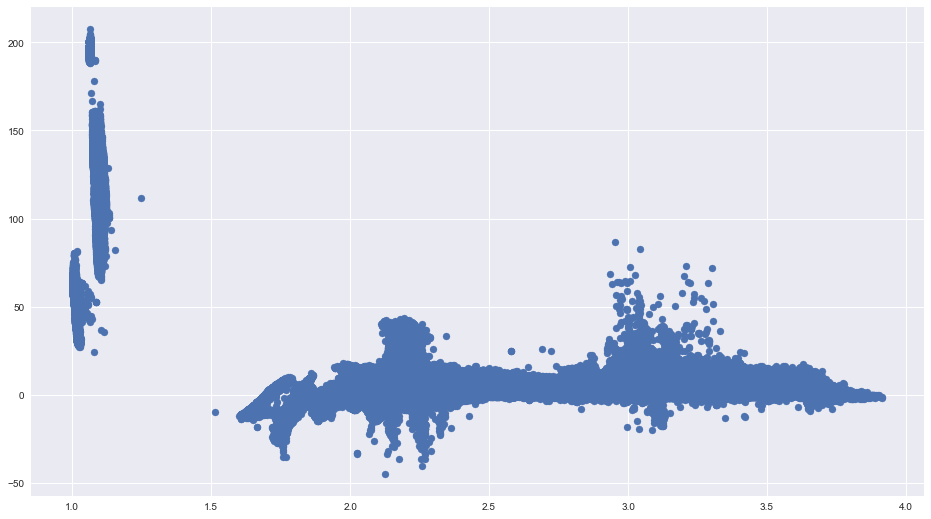

In [32]:
plt.scatter(bond_df['displacement'].values,bond_df['scalar_coupling_constant'].values)

In [37]:
bond_type = bond_types[0]
x, y = get_displacement_coupling(bond_df, bond_type )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=433)
x_test.sort() # Sort training values (mostly for plotting)

X_train = np.array([list(a) for a in list(zip(x_train,y_train))])
X_test = np.array([list(a) for a in list(zip(x_test,y_test))])

In [51]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label=[1]*531849 )
dtest = xgb.DMatrix(X_test)
# specify parameters via map
param = {}
num_round = 2
bst = xgb.train(param, dtrain)
# make prediction
preds = bst.predict(dtest)

In [63]:
preds.size

177284

ValueError: x and y must be the same size

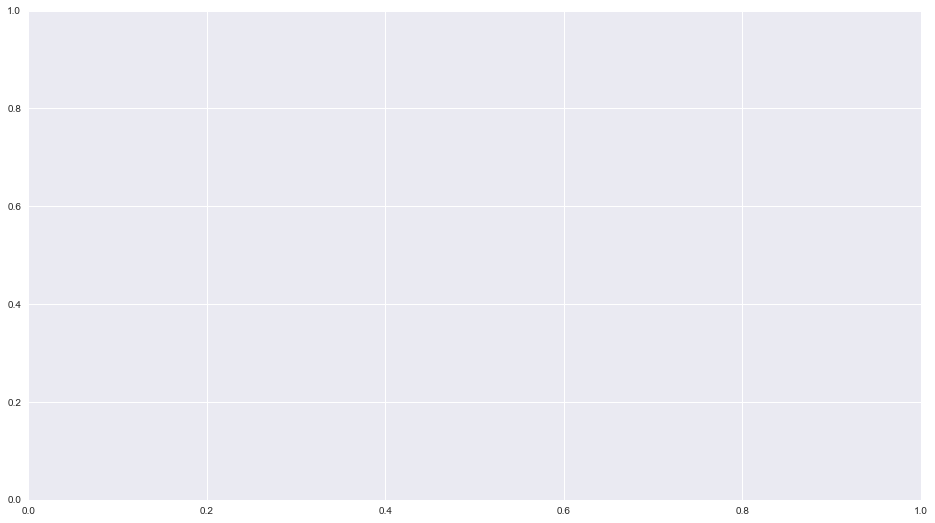

In [53]:
plt.scatter(dtest, preds)